not found for camera_cal/calibration1.jpg
not found for camera_cal/calibration4.jpg
not found for camera_cal/calibration5.jpg


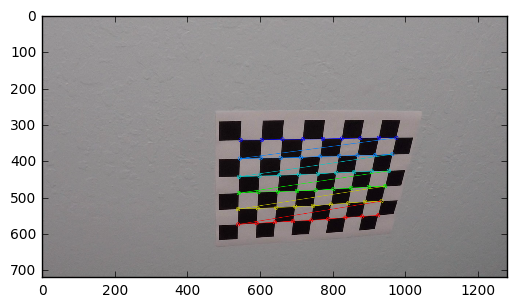

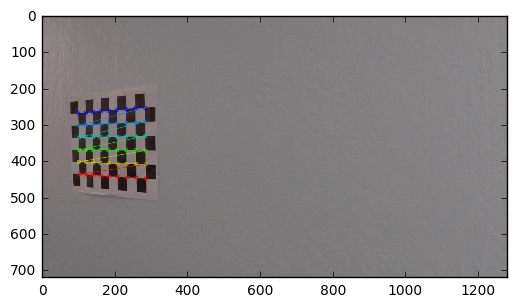

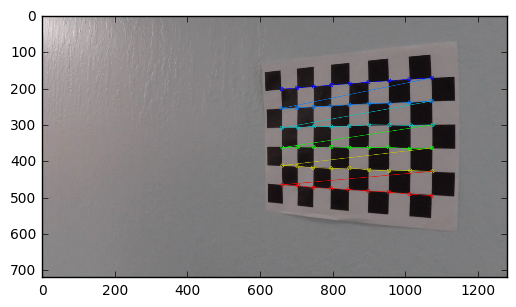

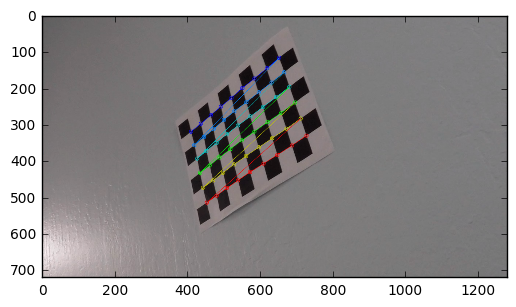

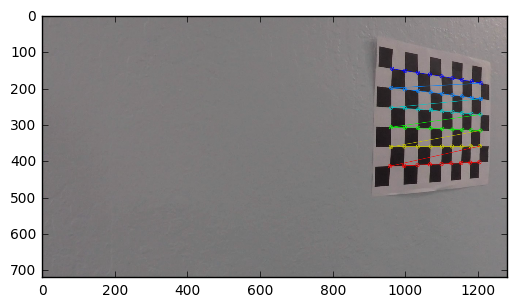

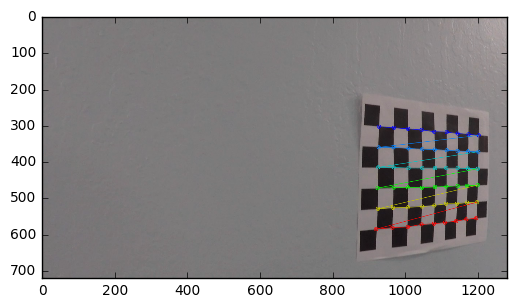

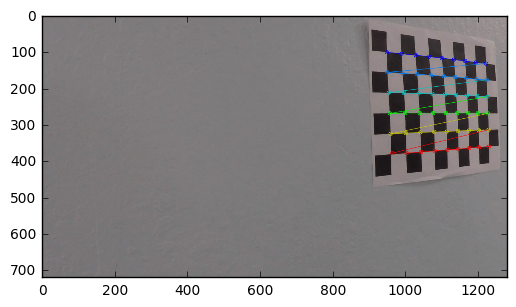

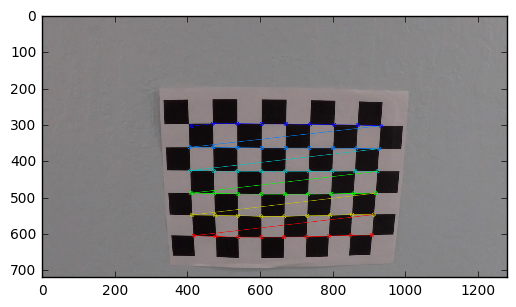

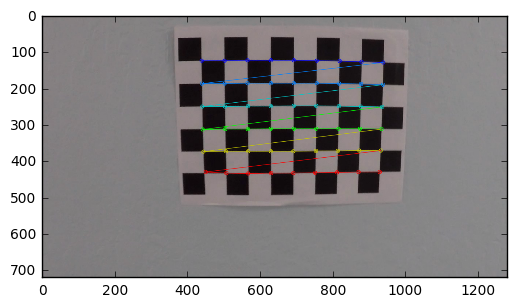

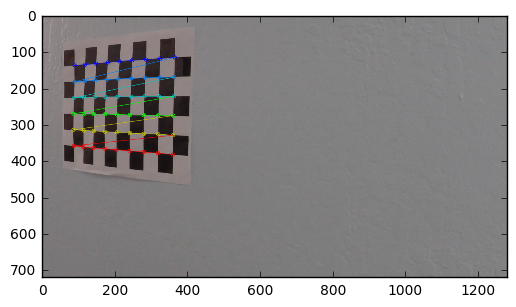

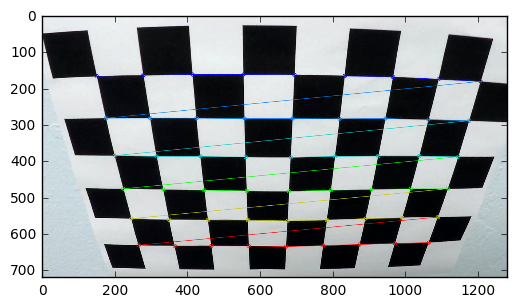

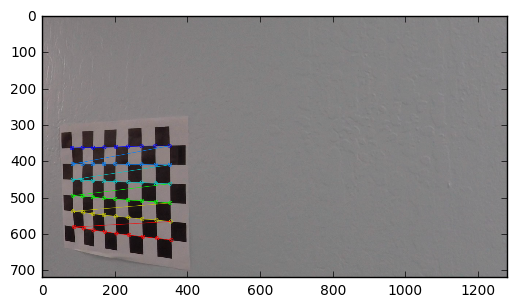

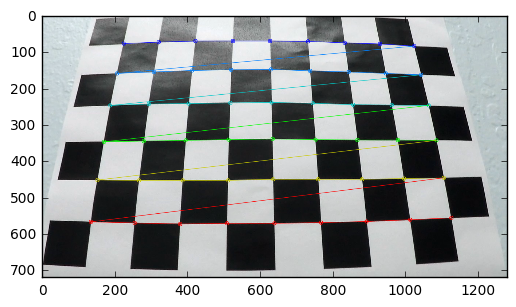

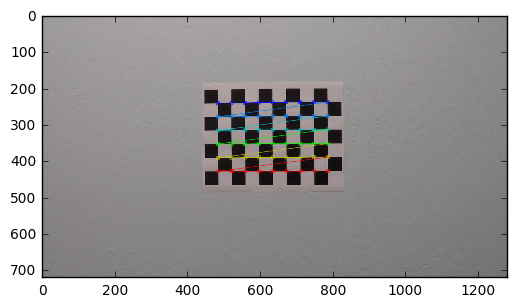

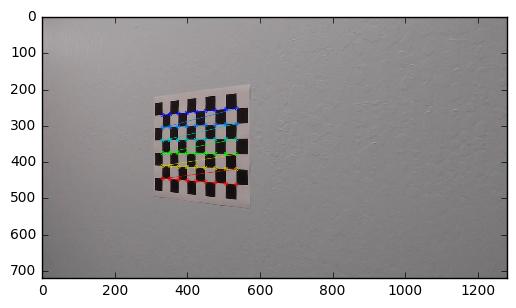

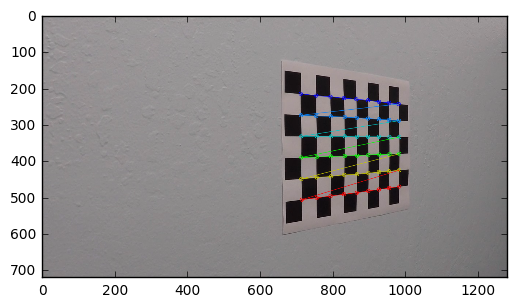

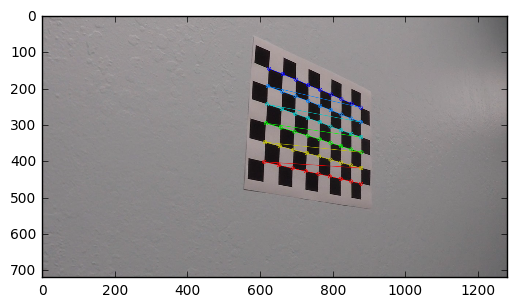

In [1]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

grid_width = 9
grid_height = 6
# camera calibration
objp = np.zeros((grid_width*grid_height, 3), np.float32)
objp[:,:2] = np.mgrid[0:grid_width, 0:grid_height].T.reshape(-1, 2)

# arrays to store real 3d points and image pixel values
objpoints = []
imgpoints = []

img_shape = None

images = glob.glob('camera_cal/*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    if img_shape is None:
        img_shape = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, 
                                             (grid_width, grid_height), 
                                             None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, 
                                  (grid_width, grid_height), 
                                  corners, 
                                  ret)
        plt.figure()
        plt.imshow(img)
    else:
        print('not found for %s' % fname)

image shape is (720, 1280, 3)


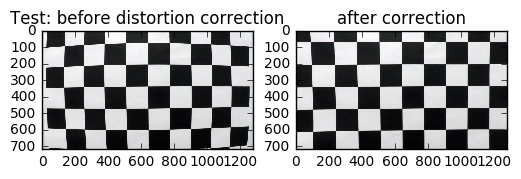

In [2]:
# calibrate camera
print('image shape is {}'.format(img_shape))
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape[:2], None, None)

test_img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(test_img, mtx, dist, None, mtx)
plt.subplot(121)
plt.imshow(test_img)
plt.title('Test: before distortion correction')
plt.subplot(122)
plt.imshow(dst)
plt.title('after correction')

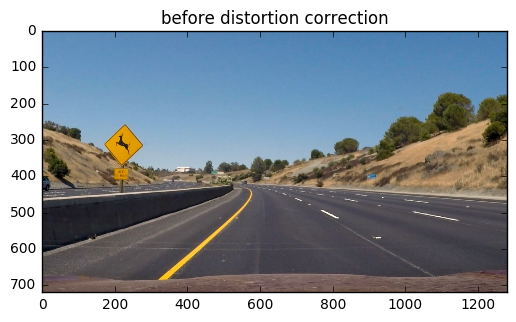

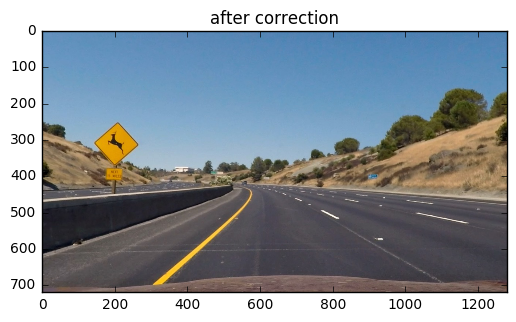

In [3]:
# distortion correction
test_images = glob.glob('test_images/*.jpg')
undistorted = {}
for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    undistorted[fname] = cv2.undistort(img, mtx, dist, None, mtx)
    # visualize before and after camera distortion correction
    if fname.endswith('test2.jpg'):
        plt.figure()
        plt.imshow(img[...,::-1]); plt.title('before distortion correction')
        plt.figure()
        plt.imshow(undistorted[fname][...,::-1]); plt.title('after correction')

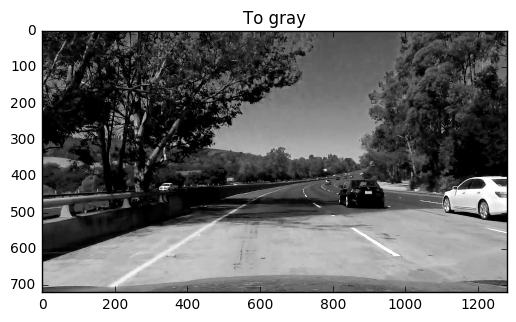

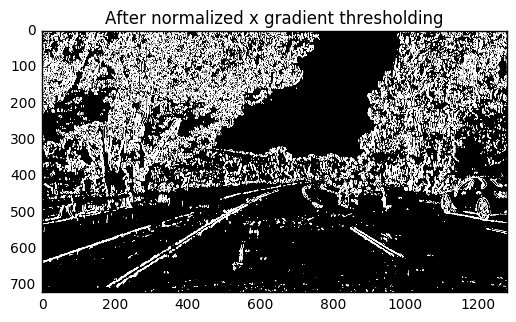

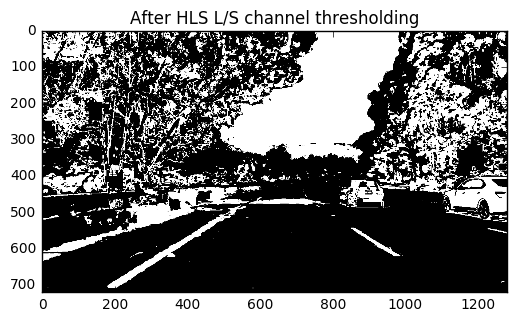

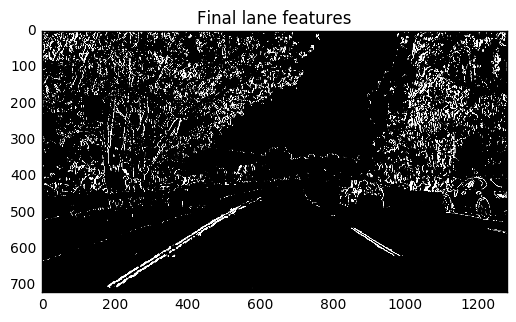

In [4]:
# apply threholding
def threshold(img_in, debug = False, save = False, img_name = None, save_dir = None):
    shape = img_in.shape[:2]
    # convert image to gray (use red channel)
    # gray = cv2.cvtColor(undistorted[img_name], cv2.COLOR_RGB2GRAY)
    gray = np.array(img_in[...,2])
    # get x direction gradient
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9)
    abs_sobel = np.absolute(sobel)
    norm_sobel = np.uint8(255.*abs_sobel/(np.max(abs_sobel)))
    sobel_result = np.zeros(shape)
    sobel_result[(norm_sobel > 10) & (norm_sobel < 100)] = 1 
    # apply HLS
    hls = cv2.cvtColor(img_in, cv2.COLOR_RGB2HLS)
    hls_s_result = np.zeros(shape)
    hls_s_result[((hls[...,1] > 190) & (hls[...,1] <= 255)) | (hls[...,2] > 80)] = 1
    # combine the two
    final = np.zeros(shape)
    final[(hls_s_result == 1) & (sobel_result == 1)] = 1
    if debug:
        plt.figure(); plt.imshow(gray, cmap='gray'); plt.title('To gray')
        plt.figure(); plt.imshow(sobel_result, cmap='gray'); plt.title('After normalized x gradient thresholding')
        plt.figure(); plt.imshow(hls_s_result, cmap='gray');plt.title('After HLS L/S channel thresholding')
        plt.figure(); plt.imshow(final, cmap='gray');plt.title('Final lane features')
    if save:
        cv2.imwrite('{}/thresholded_{}'.format(save_dir, 
                                               img_name.split('/')[-1]), 
                    final*255.0)
    return final

thresholded = {}
for img_name in undistorted.keys():
    thresholded[img_name] = threshold(undistorted[img_name], 
                           debug = img_name.endswith('test5.jpg'),
                           save = True,
                           img_name = img_name,
                           save_dir = 'output_images')
        

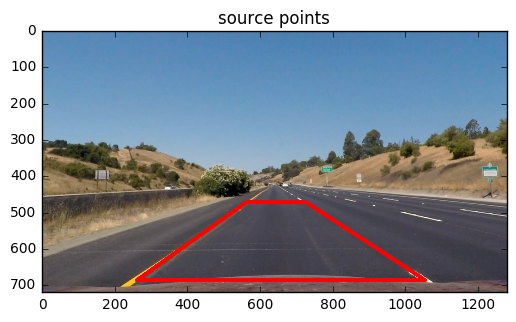

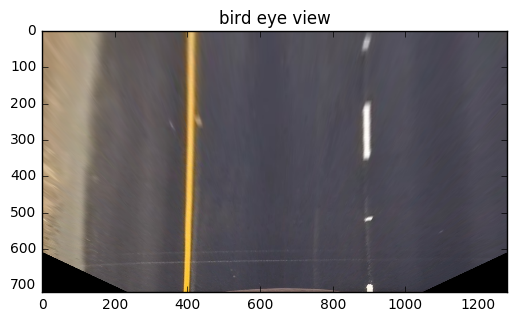

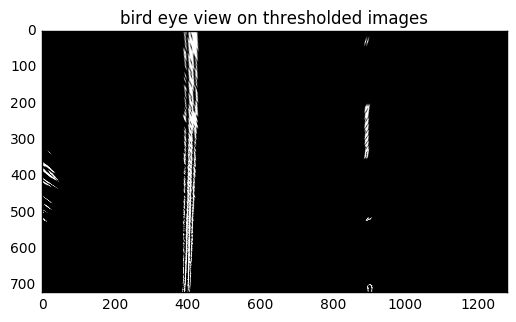

In [6]:
# apply perspective transform
test_img = 'test_images/straight_lines1.jpg'
raw_undistorted = undistorted[test_img]
draw_range = raw_undistorted.copy()
src_pts = np.float32([(260, 687), (560, 473), (725, 473), (1052, 687)])
# chosen arbitrarily for a better visualization
dst_pts = np.float32([(400, 720), (400, 0), (900, 0), (900, 720)])
for idx, line in enumerate(src_pts):
    cv2.line(draw_range, tuple(src_pts[idx]), tuple(src_pts[(idx+1)%len(src_pts)]), (0, 0, 255), 10)
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped = cv2.warpPerspective(raw_undistorted, M, img_shape[:2][::-1])
warped_thresholded = cv2.warpPerspective(thresholded[test_img], M, img_shape[:2][::-1])
plt.figure(); plt.imshow(draw_range[...,::-1]); plt.title('source points')
plt.figure(); plt.imshow(warped[...,::-1]); plt.title('bird eye view')
plt.figure(); plt.imshow(warped_thresholded, cmap='gray'); plt.title('bird eye view on thresholded images')
birdeye_thresholded = {}
birdeye_undistorted = {}
# save bird eye view images for all images
for img_name in undistorted.keys():
    warped = cv2.warpPerspective(thresholded[img_name], M, img_shape[:2][::-1])
    birdeye_thresholded[img_name] = warped
    cv2.imwrite('output_images/birdeye_thresholded_{}'.format(img_name.split('/')[-1]), warped*255.0)
    warped = cv2.warpPerspective(undistorted[img_name], M, img_shape[:2][::-1])
    birdeye_undistorted[img_name] = warped
    cv2.imwrite('output_images/birdeye_undistorted_{}'.format(img_name.split('/')[-1]), warped)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


base x: left-369.00, right-929.00
Image: test_images/test5.jpg; fit x = Ay^2 + By + C;
Left : A=8.844260655877741e-05, B=-0.1305077987298485
Right: A=8.091613325612426e-05, B=-0.10866608410771371
Curvature in pixel space: left 5653.47; right 6179.81
Offcenter in pixel space: -9.37
Curvature in meter space: left 2253.58; right 2393.62
Offcenter in meter space: -0.05


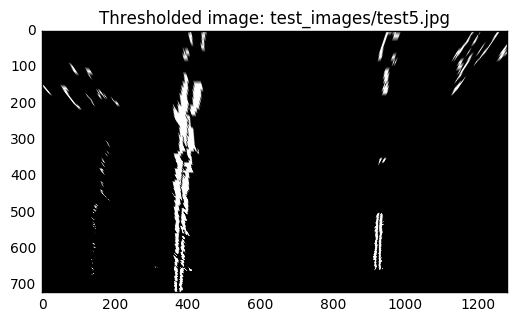

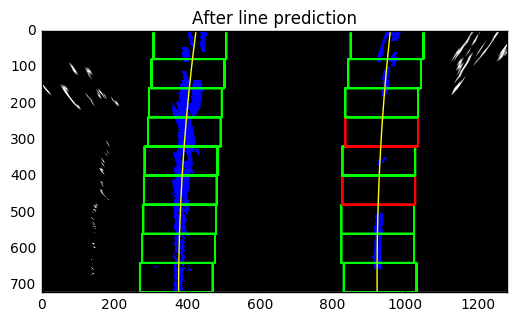

In [8]:
# lane detection and visualizations
def detect_lane(img_in, debug = False, save = False, img_name = None, save_dir = None, meter_per_pixel = None):
    out_img = np.dstack((img_in, img_in, img_in))
    height, width = img_in.shape
    nwindows = 9
    window_height = int(height/nwindows)
    # x: center of small windows
    left_xs = []
    right_xs = []
    left_lane_inds = []
    right_lane_inds = []
    # x and y positions of all non-zeros pixels
    nonzeros = img_in.nonzero()
    nonzerosy = np.array(nonzeros[0])
    nonzerosx = np.array(nonzeros[1])
    # margins in x
    marginx = 100
    minpixels = 30
    
    # find starting point at bottom for left and right lane
    bottom_histogram = np.sum(img_in[height/2:, :], axis = 0)
    left_x_base= np.argmax(bottom_histogram[:width/2])
    right_x_base = np.argmax(bottom_histogram[width/2:]) + int(width/2)
    left_xs.append(left_x_base)
    right_xs.append(right_x_base)
    
    # apply histogram at each layer
    for window in range(nwindows):
        x_left_low = left_xs[-1] - marginx
        x_left_high = left_xs[-1] + marginx
        x_right_low = right_xs[-1] - marginx
        x_right_high = right_xs[-1] + marginx
        y_low = height - (window+1)*window_height
        y_high = height - (window)*window_height
        good_left_inds = ((nonzerosx >= x_left_low) &
                          (nonzerosx < x_left_high) &
                          (nonzerosy >= y_low) &
                          (nonzerosy < y_high)).nonzero()[0]
        good_right_inds = ((nonzerosx >= x_right_low) &
                          (nonzerosx < x_right_high) &
                          (nonzerosy >= y_low) &
                          (nonzerosy < y_high)).nonzero()[0]
        if (len(good_left_inds) > minpixels):
            left_xs.append(int(np.mean(nonzerosx[good_left_inds])))
            left_lane_inds.extend(good_left_inds)
            if debug or save:
                out_img[((nonzerosy[good_left_inds],
                          nonzerosx[good_left_inds]))] = (0, 0, 1)
                cv2.rectangle(out_img, (x_left_low, y_low), 
                              (x_left_high, y_high), (0, 1, 0), 5)
        elif debug or save:
            cv2.rectangle(out_img, (x_left_low, y_low), 
                              (x_left_high, y_high), (1, 0, 0), 5)
        if (len(good_right_inds) > minpixels):
            right_xs.append(int(np.mean(nonzerosx[good_right_inds])))
            right_lane_inds.extend(good_right_inds)
            if debug or save:
                out_img[((nonzerosy[good_right_inds],
                          nonzerosx[good_right_inds]))] = (0, 0, 1)
                cv2.rectangle(out_img, (x_right_low, y_low), 
                              (x_right_high, y_high), (0, 1, 0), 5)
        elif debug or save:
            cv2.rectangle(out_img, (x_right_low, y_low), 
                          (x_right_high, y_high), (1, 0, 0), 5)

    # fit a second order poly
    leftx = nonzerosx[left_lane_inds]
    lefty = nonzerosy[left_lane_inds]
    rightx = nonzerosx[right_lane_inds]
    righty = nonzerosy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_poly = np.poly1d(left_fit)
    right_poly = np.poly1d(right_fit)
    left_lane_start = left_poly(height-1)
    right_lane_start = right_poly(height-1)
    off_center = width/2 - (left_lane_start+right_lane_start)/2
    
    if debug:
        print('base x: left-{:.2f}, right-{:.2f}'.format(left_x_base, right_x_base))
        plt.figure(); plt.imshow(img_in, cmap='gray'); plt.title('Thresholded image: {}'.format(img_name))
        # visualization
        ploty = np.linspace(0, height)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        plt.figure(); plt.imshow(out_img); plt.title('After line prediction')
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, width)
        plt.ylim(height, 0)
    if save:
         cv2.imwrite('{}/lane_{}'.format(save_dir, 
                                         img_name.split('/')[-1]), 
                    out_img*255)
            
    if not meter_per_pixel is None:
        left_fit_m = np.polyfit(lefty * meter_per_pixel[0], leftx * meter_per_pixel[1], 2)
        right_fit_m = np.polyfit(righty * meter_per_pixel[0], rightx * meter_per_pixel[1], 2)
        off_center_m = off_center * meter_per_pixel[1]
        return left_fit, right_fit, off_center, left_fit_m, right_fit_m, off_center_m
    else:
        return left_fit, right_fit, off_center, None, None, None

ym_per_pix = 30./720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
meter_per_pixel = [ym_per_pix, xm_per_pix]
for img_name in birdeye_thresholded.keys():
    # Define conversions in x and y from pixels space to meters
    left_fit, right_fit, off_center, left_fit_m, right_fit_m, off_center_m = detect_lane(birdeye_thresholded[img_name], 
                            debug=img_name.endswith('test5.jpg'),
                            save=True,
                            img_name=img_name,
                            save_dir='output_images/',
                            meter_per_pixel = meter_per_pixel)
    if img_name.endswith('test5.jpg'):
        print('Image: {}; fit x = Ay^2 + By + C;'.format(img_name))
        print('Left : A={}, B={}'.format(left_fit[0], left_fit[1]))
        print('Right: A={}, B={}'.format(right_fit[0], right_fit[1]))
        y_eval = birdeye_thresholded[img_name].shape[0]
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        print('Curvature in pixel space: left {:.2f}; right {:.2f}'.format(left_curverad, right_curverad))
        print('Offcenter in pixel space: {:.2f}'.format(off_center))
        if not left_fit_m is None:
            left_curverad_m = ((1 + (2*left_fit_m[0]*y_eval + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
            right_curverad_m = ((1 + (2*right_fit_m[0]*y_eval + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
            print('Curvature in meter space: left {:.2f}; right {:.2f}'.format(left_curverad_m, right_curverad_m))
            print('Offcenter in meter space: {:.2f}'.format(off_center_m))
        

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


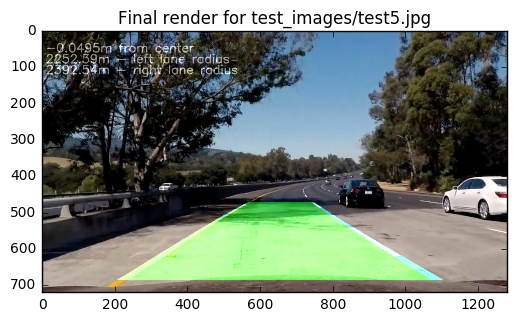

In [10]:
# wrap back to original image
def detect_lane_e2e(img_in, mtx, dist, perspectiveM, meter_per_pixel, lane_thickness = 21,
                    debug = False, save = False, img_name = None, save_dir = None):
    img_shape = img_in.shape
    height = img_shape[0]
    undistort_0 = cv2.undistort(img_in, mtx, dist, None, mtx)
    threshold_1 = threshold(undistort_0)
    warped_2 = cv2.warpPerspective(threshold_1, M, img_shape[:2][::-1])
    out_img_3 = np.dstack((warped_2, warped_2, warped_2))
    out_img_4 = np.zeros_like(img_in)
    
    # visualization on wrapped image
    left_fit, right_fit, off_center, left_fit_m, right_fit_m, off_center_m = detect_lane(warped_2, meter_per_pixel = meter_per_pixel)
    y_eval = img_shape[0]-1
    left_curverad_m = ((1 + (2*left_fit_m[0]*y_eval + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_curverad_m = ((1 + (2*right_fit_m[0]*y_eval + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
            
    left_poly = np.poly1d(left_fit)
    right_poly = np.poly1d(right_fit)
    ploty = np.linspace(0, height-1, height)
    leftx = left_poly(ploty)
    rightx = right_poly(ploty)
    left_pts = np.array([ploty, leftx], dtype=np.int32)
    right_pts = np.array([ploty, rightx], dtype=np.int32)
    
    # fill out area between lanes
    for ind, h in enumerate(ploty):
        out_img_4[h][int(left_pts[1][h]):int(right_pts[1][h])] = (0, 255, 0)
        
    # extend thickness of marked lanes
    for dx in range(-int(lane_thickness/2), int(lane_thickness/2)+1, 1):
        left_extend = left_pts[1] + dx
        right_extend = right_pts[1] + dx
        out_img_4[(left_pts[0], [(0 if x < 0 else (img_shape[1]-1 if x >= img_shape[1] else x)) for x in left_extend])] = (255, 255, 0)
        out_img_4[(right_pts[0], [(0 if x < 0 else (img_shape[1]-1 if x >= img_shape[1] else x)) for x in right_extend])] = (255, 255, 0)
    
    # warp back the illustrations
    warpedback_5 = cv2.warpPerspective(out_img_4, np.linalg.inv(M), img_shape[:2][::-1])
    
    # put text about curvature and distance from center
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(warpedback_5,'{:.3}m from center'.format(off_center_m),
                (10,60), font, 1.1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(warpedback_5,'{:.2f}m - left lane radius'.format(left_curverad_m),
                (10,90), font, 1.1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(warpedback_5,'{:.2f}m - right lane radius'.format(right_curverad_m),
                (10,120), font, 1.1,(255,255,255),2,cv2.LINE_AA)
    added_6 = cv2.addWeighted(undistort_0, 1, warpedback_5, 0.5, 0)
    if debug:
        plt.figure()
        plt.title('Final render for {}'.format(img_name))
        plt.imshow(added_6[...,::-1])
        plt.show()
    if save:
        cv2.imwrite('{}/final_{}'.format(save_dir, 
                                         img_name.split('/')[-1]), 
                    added_6)
    return added_6
        
    
for img_name in test_images:
    img_in = cv2.imread(img_name)
    detect_lane_e2e(img_in, mtx, dist, M, meter_per_pixel, debug=img_name.endswith('test5.jpg'), img_name=img_name, save=True, save_dir='output_images')

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    result = detect_lane_e2e(image, mtx, dist, M, meter_per_pixel)
    return result

In [12]:
challenge_output = 'project_video_output.mp4'
clip2 = VideoFileClip('project_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:35<00:00,  2.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 28s, sys: 45.6 s, total: 6min 14s
Wall time: 6min 37s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))


# Discussions
## Issues faced and space for improvements
* When applying thresholds in Sobel and HLS color spaces, the thresholds are tuned given a small number of test images. They might not be robust enough say for extreme lighting conditions and different tarmac.
* Lane detection could fail when a lane is covered by another vehicle, which could bring significant noise into feature point extraction and histogram weighing
* The pixel to meter rate needs to be calibrated (say using stereo camera) to achieve high-accuracy curvature results